In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import re
from sklearn.feature_extraction.text import CountVectorizer
import time



In [2]:
# Load and preprocess the data
DATASET_COLUMNS = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('C:/Users/IDEH/Desktop/Sentimental/Data/Sentiment140.csv',
                      encoding=DATASET_ENCODING, names=DATASET_COLUMNS)




In [3]:
# Map sentiment labels to integers (0: negative, 4: positive)
sentiment_map = {0: 0, 4: 1}  # 0: negative, 1: positive
dataset.loc[:, 'sentiment'] = dataset['sentiment'].map(sentiment_map)



In [4]:
# Preprocess the text data
def preprocess(textdata):
    processedText = []
    wordLemm = WordNetLemmatizer()
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in tqdm(textdata, desc="Processing tweets", unit="tweet"):
        tweet = tweet.lower()
        tweet = re.sub(urlPattern, ' URL', tweet)
        tweet = re.sub(userPattern, ' USER', tweet)
        tweet = re.sub(alphaPattern, " ", tweet)
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        tweetwords = ''
        for word in tweet.split():
            word = wordLemm.lemmatize(word)
            tweetwords += (word + ' ')
        processedText.append(tweetwords)

    return processedText



In [5]:
processed_text = preprocess(dataset['text'].values)



Processing tweets: 100%|██████████| 1600000/1600000 [05:40<00:00, 4692.93tweet/s] 


In [6]:
count_vectorizer = CountVectorizer(max_features=20000, stop_words='english', ngram_range=(1, 2), min_df=5, max_df=0.8)

In [7]:
# Vectorize the text data
start_time = time.time()
X_counts = count_vectorizer.fit_transform(tqdm(processed_text, desc="Vectorizing text data", unit="document"))
end_time = time.time()
print(f"Vectorization completed in {end_time - start_time:.2f} seconds")



Vectorizing text data: 100%|██████████| 1600000/1600000 [01:22<00:00, 19405.19document/s]


Vectorization completed in 115.64 seconds


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_counts, dataset['sentiment'].values, test_size=0.2, random_state=0)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)



In [9]:
# Convert sparse matrix to tensorflow sparse tensor
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)



In [10]:
X_train_sparse = convert_sparse_matrix_to_sparse_tensor(X_train)
X_val_sparse = convert_sparse_matrix_to_sparse_tensor(X_val)
X_test_sparse = convert_sparse_matrix_to_sparse_tensor(X_test)

# Reorder the SparseTensors
X_train_sparse = tf.sparse.reorder(X_train_sparse)
X_val_sparse = tf.sparse.reorder(X_val_sparse)
X_test_sparse = tf.sparse.reorder(X_test_sparse)



In [11]:
# Define the model
def create_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model



In [12]:
# Create and compile the model
model = create_model(X_counts.shape[1])

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [13]:

# Train the model
history = model.fit(X_train_sparse, y_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(X_val_sparse, y_val),
                    callbacks=[early_stopping],
                    verbose=1)



Epoch 1/10
4000/4000 [==============================] - 486s 120ms/step - loss: 0.4878 - accuracy: 0.7689 - val_loss: 0.4610 - val_accuracy: 0.7823
Epoch 2/10
4000/4000 [==============================] - 498s 123ms/step - loss: 0.4549 - accuracy: 0.7871 - val_loss: 0.4599 - val_accuracy: 0.7857
Epoch 3/10
4000/4000 [==============================] - 506s 126ms/step - loss: 0.4346 - accuracy: 0.7988 - val_loss: 0.4576 - val_accuracy: 0.7860
Epoch 4/10
4000/4000 [==============================] - 524s 129ms/step - loss: 0.4146 - accuracy: 0.8101 - val_loss: 0.4607 - val_accuracy: 0.7846
Epoch 5/10
4000/4000 [==============================] - 483s 119ms/step - loss: 0.3946 - accuracy: 0.8211 - val_loss: 0.4701 - val_accuracy: 0.7820
Epoch 6/10
4000/4000 [==============================] - 492s 122ms/step - loss: 0.3769 - accuracy: 0.8311 - val_loss: 0.4680 - val_accuracy: 0.7805


In [14]:
# Evaluate the model
y_pred = model.predict(X_test_sparse)
y_pred = (y_pred > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

10000/10000 [==============================] - 53s 5ms/step
Accuracy: 0.787053125
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.78    159815
           1       0.78      0.81      0.79    160185

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000

Confusion Matrix:
 [[122311  37504]
 [ 30639 129546]]


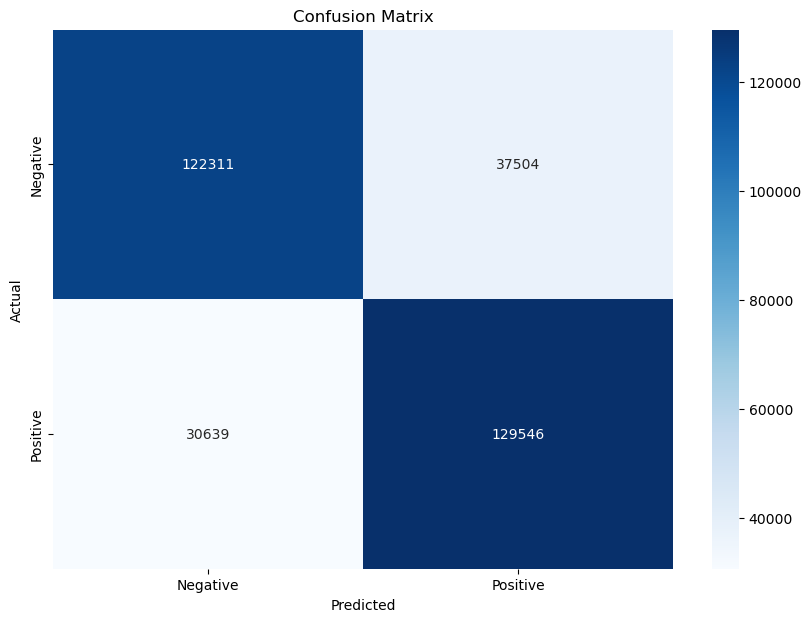

In [16]:
# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



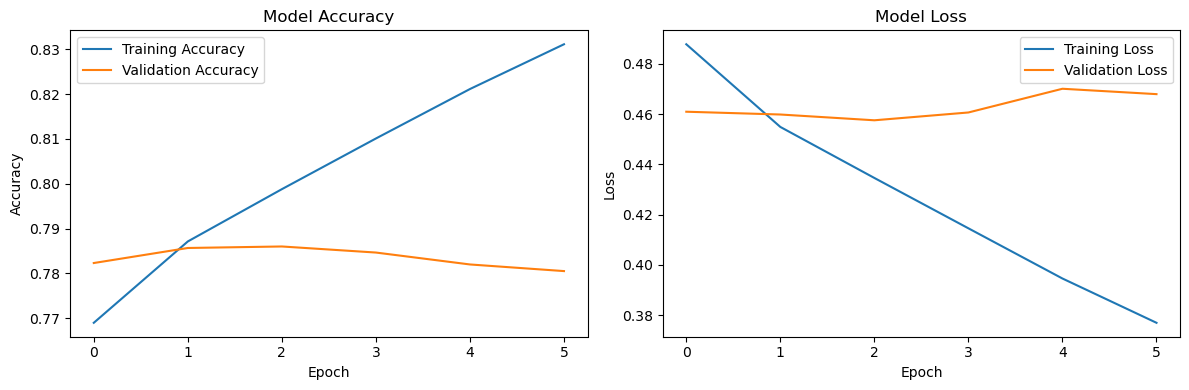

In [17]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()